In [48]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
from string import Template
PATH_TO_PYSEIR_ROOT = '/Users/xzhang/Documents/covid/county_covid_seir_models/'
sys.path.append(PATH_TO_PYSEIR_ROOT)

import numpy as np
from pyseir.models.seir_model_age import SEIRModelAge
from pyseir.models.seir_model import SEIRModel
from pyseir.models.suppression_policies import generate_triggered_suppression_model
import matplotlib.pyplot as plt
from pyseir.models.age_structure import get_age_distribution_and_contact_matrix
from pyseir import load_data

os.environ['KMP_DUPLICATE_LIB_OK']='True'

n_days = 360
t_list = np.linspace(0, n_days, n_days)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
THIS_FILE_PATH = os.path.dirname(os.path.realpath('__file__'))

In [20]:
config = dict(fips = '06075',
              contact_matrices_r_script_path = THIS_FILE_PATH + '/../pyseir/models/contact_matrices.r',
              r_substitution = dict(survey_source='polymod',
                                    country = 'United Kingdom',
                                    num_sample = 10,
                                    weight_by_dayofweek='TRUE',
                                    matrices='$matrices',
                                    matrix='$matrix'))

In [21]:
age_bin_edges, age_group_sizes, contact_matrix = get_age_distribution_and_contact_matrix(config)

R[write to console]: Using POLYMOD social contact data. To cite this in a publication, use the 'cite' function



In [22]:
# some fabricated data ...
hospitalization_rate_general = np.array([0.01, 0.01, 0.025, 0.02, 0.02, 0.03, 0.04, 0.05, 
                                         0.1, 0.2, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6])
hospitalization_rate_icu = np.array([0.001, 0.002, 0.002, 0.002, 0.003, 0.003, 0.004, 0.004, 0.005, 0.005, 
                                     0.01, 0.02, 0.02, 0.03, 0.05, 0.1])
mortality_rate = np.array([0.001, 0.001, 0.0015, 0.0015, 0.0015, 0.002, 0.003, 0.003, 
                           0.005, 0.006, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05])

In [87]:
DEFAULT_PARAM = dict(R0 = 3.5,
                     birth_rate = 0.0015,
                     delta = 1/5.2,
                     sigma = 1/5.2)
                     

### NO suppression policy

#### When there is NO age structure

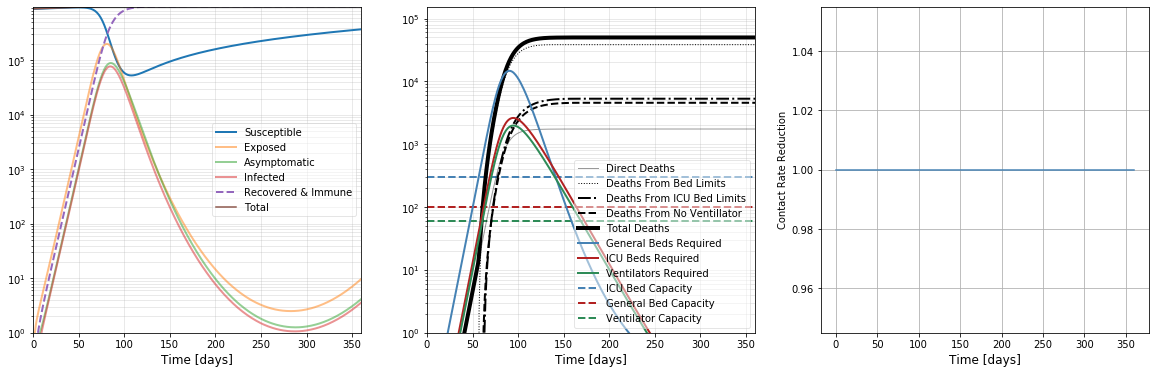

In [88]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, start_on=30, reduction=1)
model = SEIRModel(
    N=age_group_sizes.sum(),
    A_initial=1,
    I_initial=0, 
    t_list=t_list,
    hospitalization_rate_general=(hospitalization_rate_general*age_group_sizes).sum() / age_group_sizes.sum(),
    hospitalization_rate_icu=(hospitalization_rate_icu*age_group_sizes).sum() / age_group_sizes.sum(),
    mortality_rate=(mortality_rate*age_group_sizes).sum() / age_group_sizes.sum(),
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()

#### When there is age structure and homogeneous contact rates

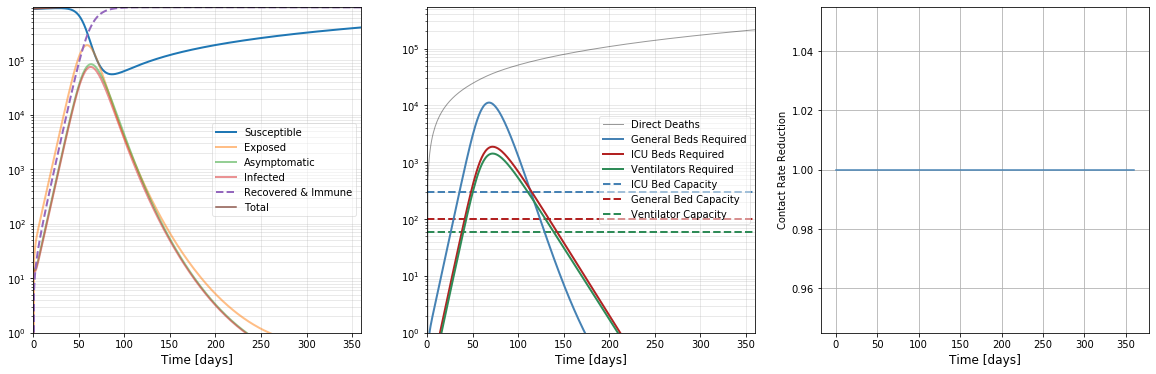

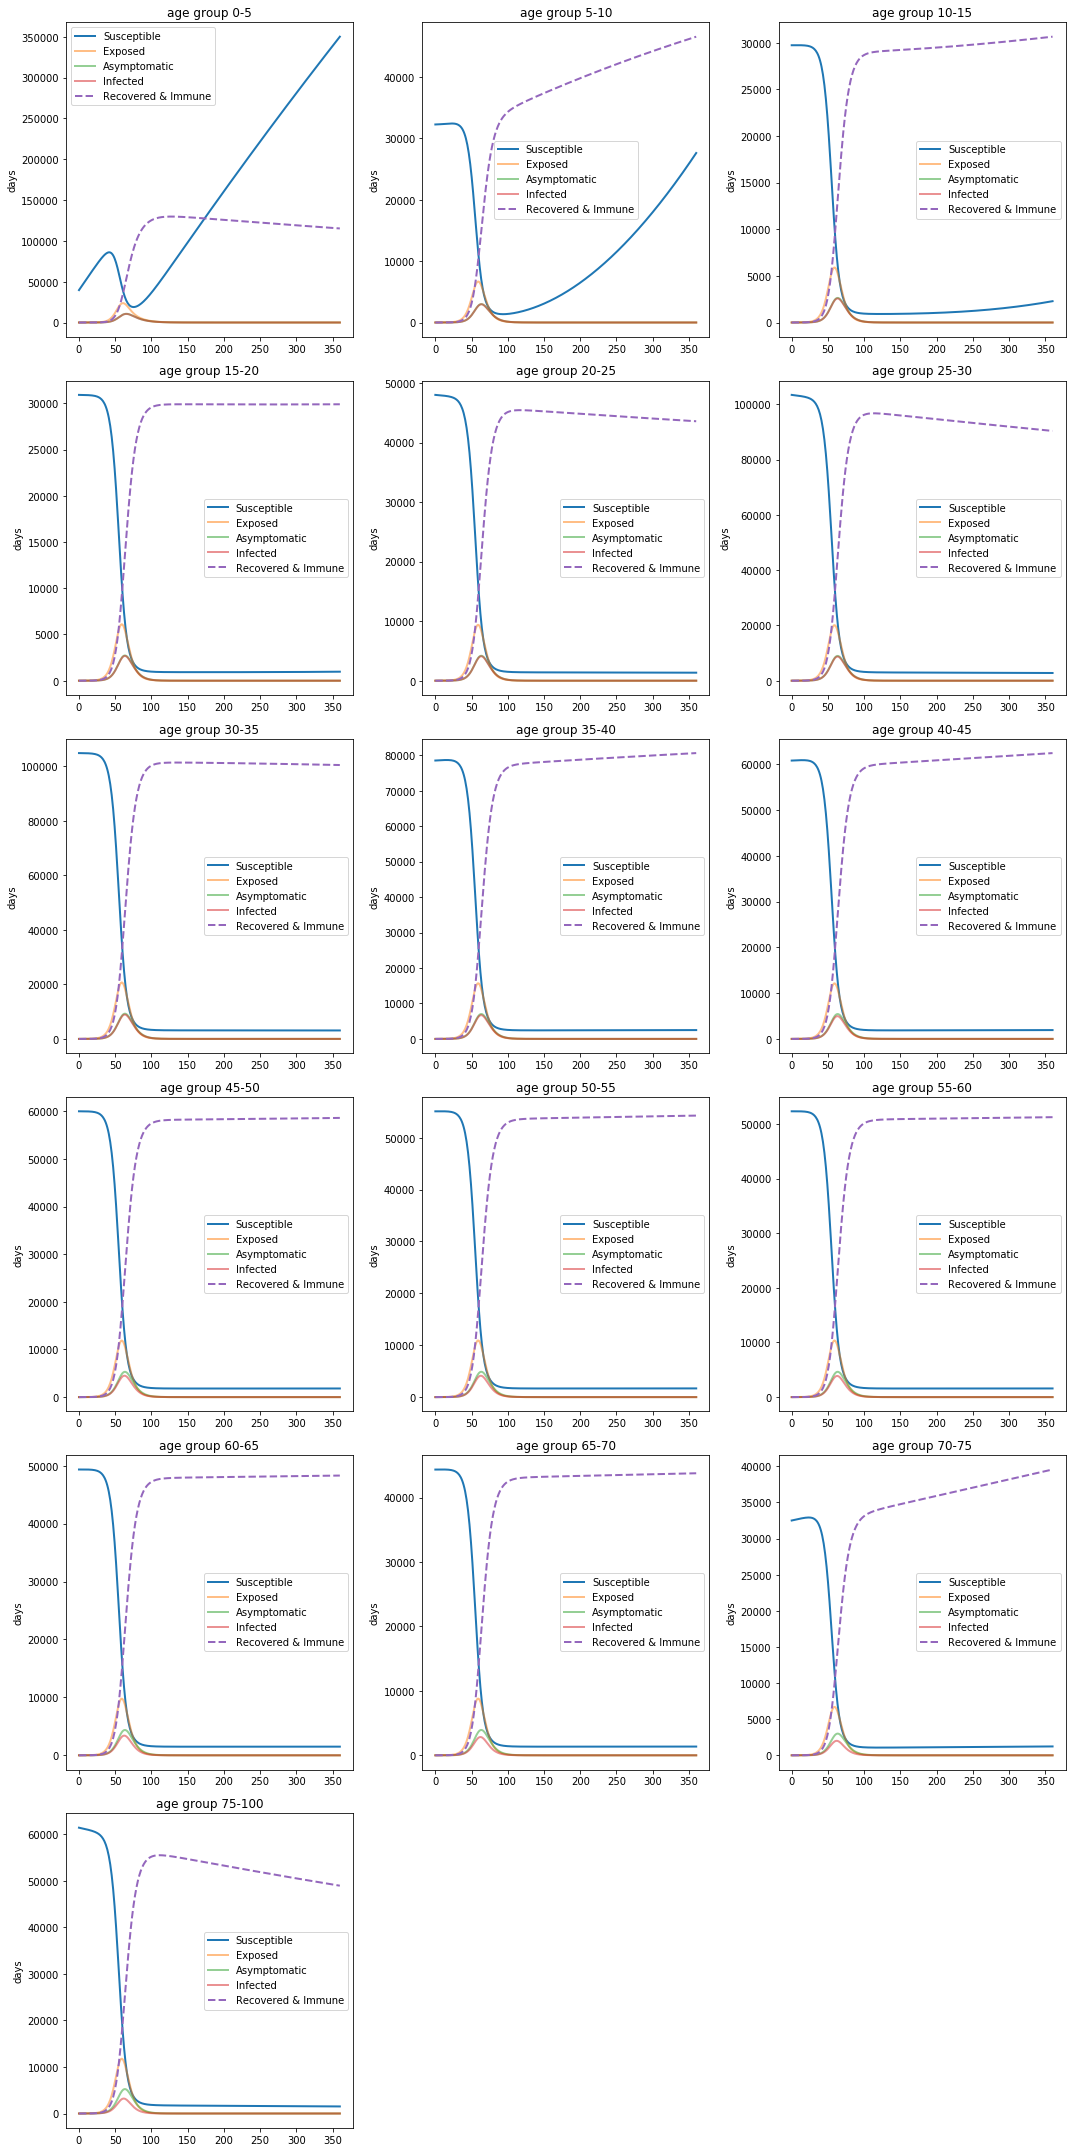

In [60]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, start_on=30, reduction=1)
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=np.zeros(age_group_sizes.shape[0]) + 1,
    I_initial=np.zeros(age_group_sizes.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=pd.DataFrame(np.zeros((16, 16)) + 1),
    D_initial=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()
model.plot_results(by_age_group=True)


#### When there is age structure and heterogeneous contact rates

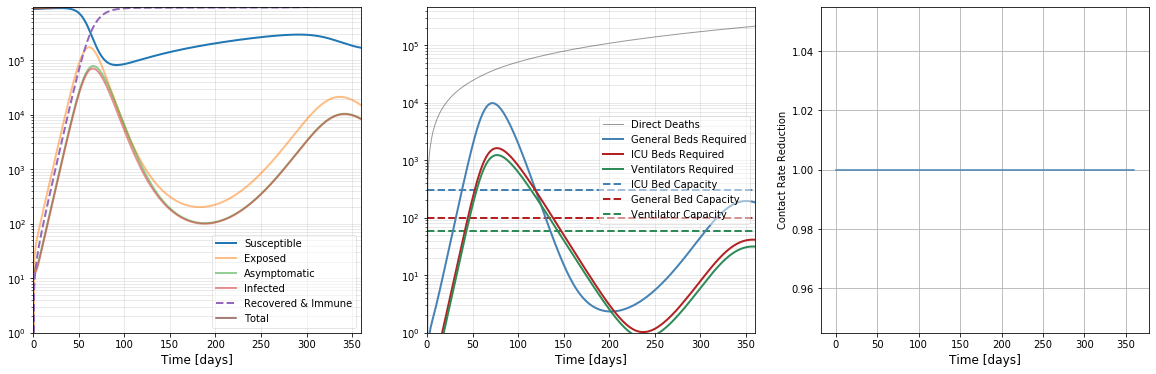

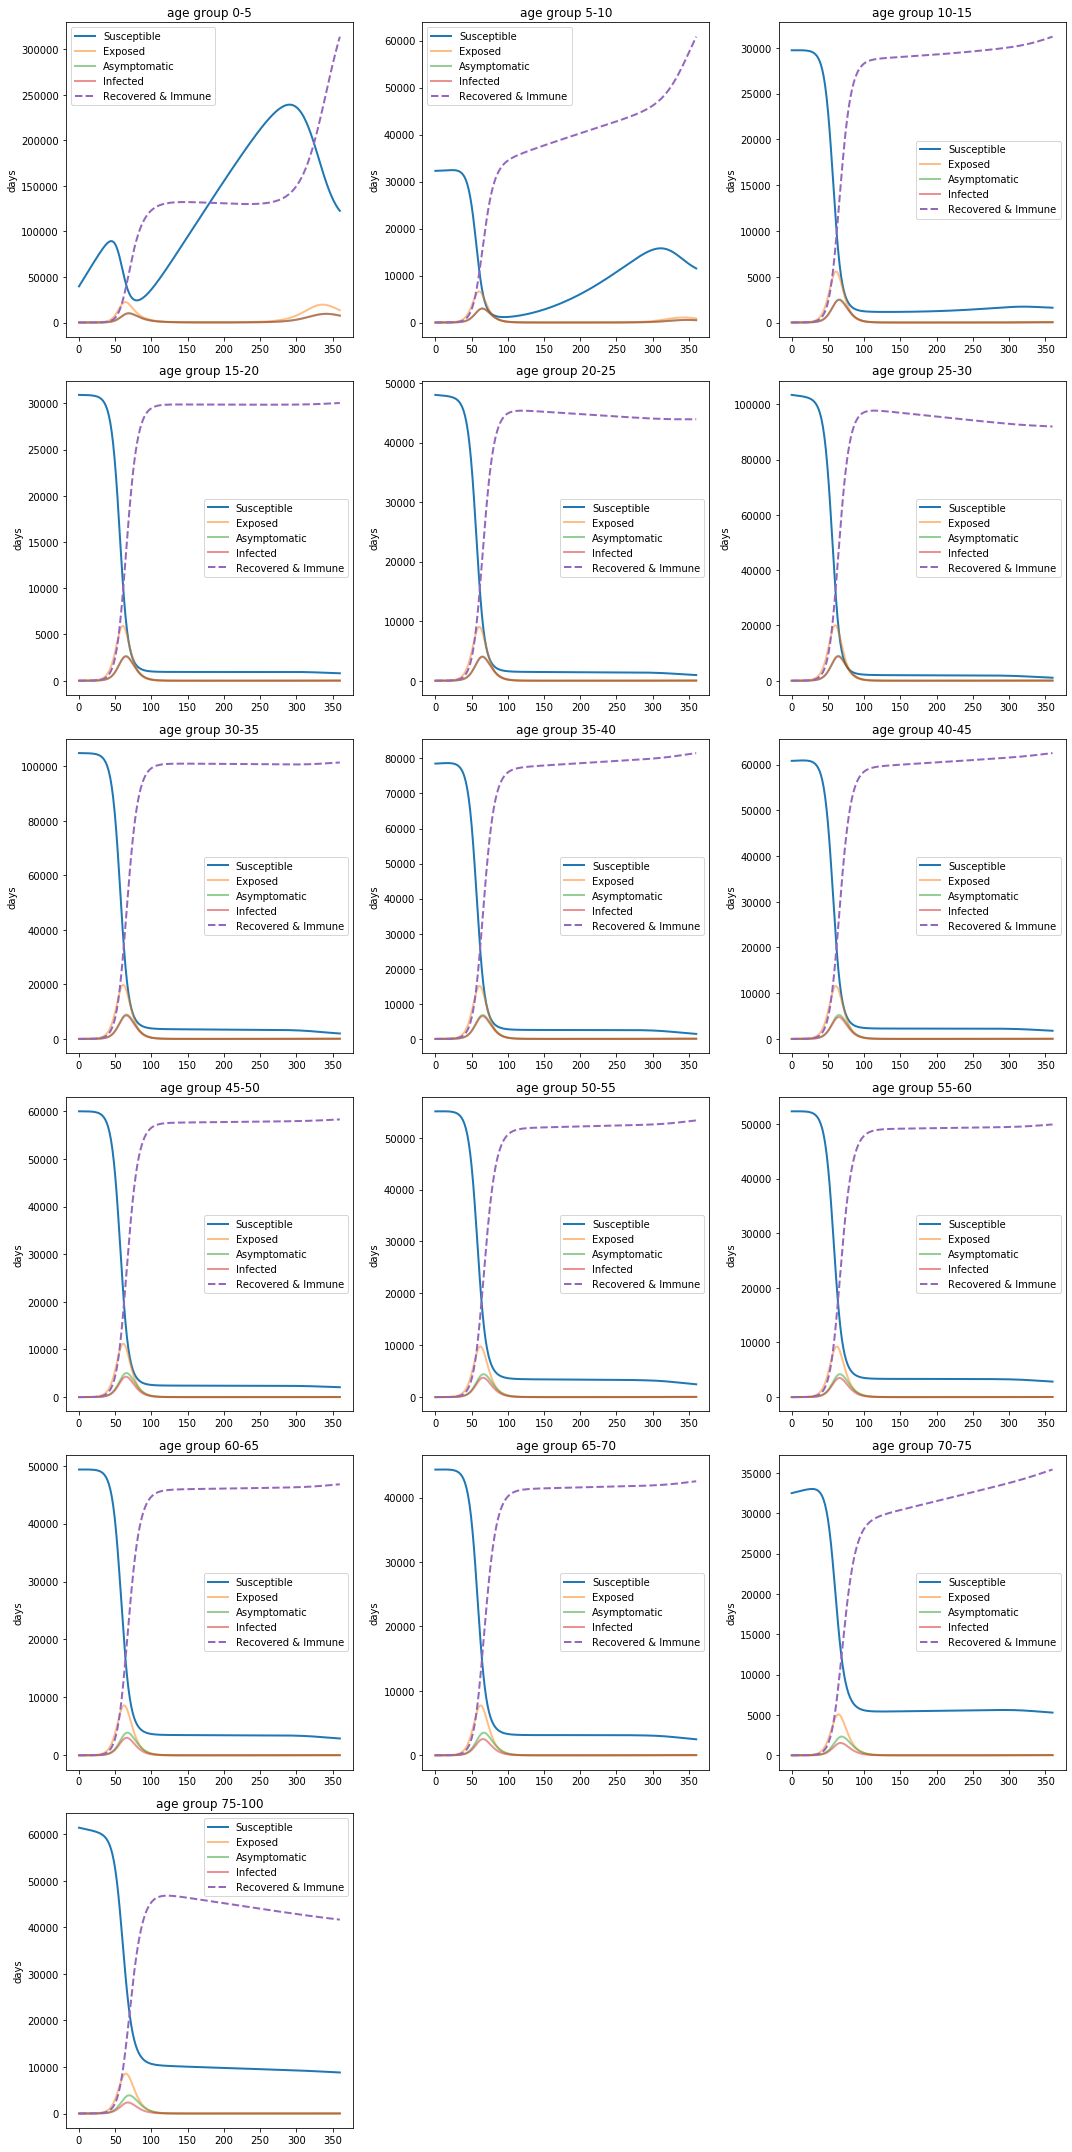

In [62]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, start_on=30, reduction=1)
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=np.zeros(age_group_sizes.shape[0]) + 1,
    I_initial=np.zeros(age_group_sizes.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()
model.plot_results(by_age_group=True)

### With suppression policy (intermediate compliance)

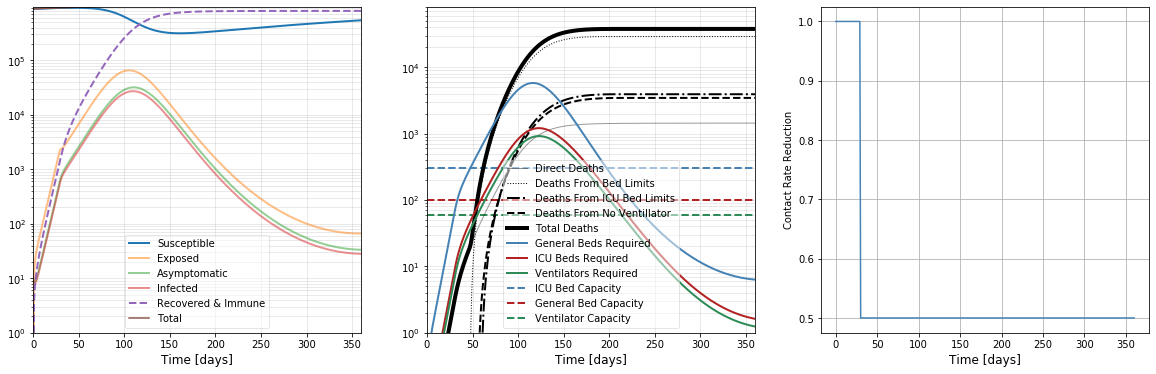

In [66]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, 
                                                          open_days=0, start_on=30, reduction=0.5)
model = SEIRModel(
    N=age_group_sizes.sum(),
    A_initial=10,
    I_initial=10, 
    t_list=t_list,
    hospitalization_rate_general=(hospitalization_rate_general*age_group_sizes).sum() / age_group_sizes.sum(),
    hospitalization_rate_icu=(hospitalization_rate_icu*age_group_sizes).sum() / age_group_sizes.sum(),
    mortality_rate=(mortality_rate*age_group_sizes).sum() / age_group_sizes.sum(),
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()

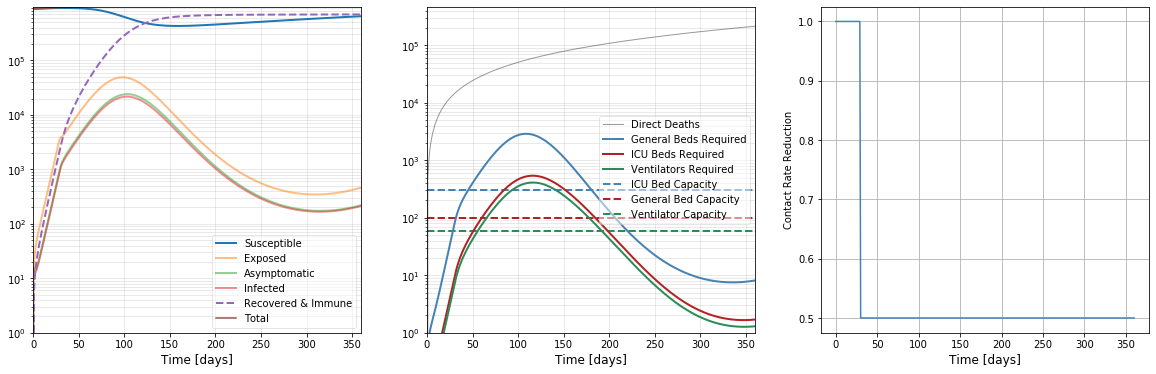

In [69]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, open_days=0, 
                                                          start_on=30, reduction=0.5)
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=np.zeros(age_group_sizes.shape[0]) + 1,
    I_initial=np.zeros(age_group_sizes.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()

### With suppression policy (good compliance)

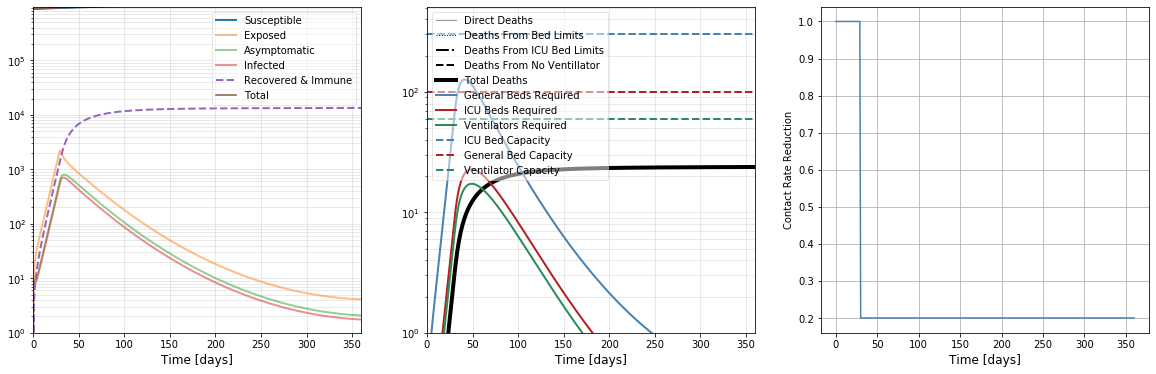

In [71]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, 
                                                          open_days=0, start_on=30, reduction=0.2)
model = SEIRModel(
    N=age_group_sizes.sum(),
    A_initial=10,
    I_initial=10, 
    t_list=t_list,
    hospitalization_rate_general=(hospitalization_rate_general*age_group_sizes).sum() / age_group_sizes.sum(),
    hospitalization_rate_icu=(hospitalization_rate_icu*age_group_sizes).sum() / age_group_sizes.sum(),
    mortality_rate=(mortality_rate*age_group_sizes).sum() / age_group_sizes.sum(),
    suppression_policy=suppression_policy,
    **DEFAULT_PARAM)

model.run()
model.plot_results()

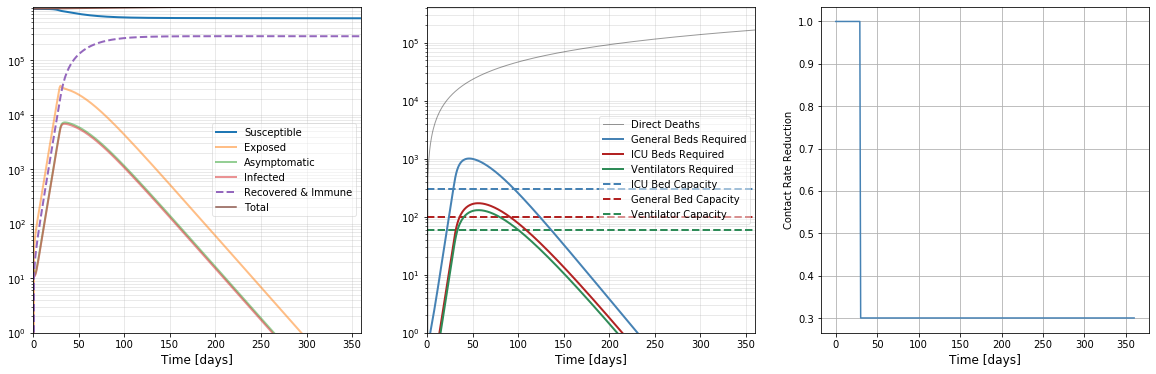

In [72]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, open_days=0, start_on=30, reduction=0.3)
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=np.zeros(age_group_sizes.shape[0]) + 1,
    I_initial=np.zeros(age_group_sizes.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    birth_rate=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    R0=R0,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

#### Test of R0
Infection curve should gose down when R0 < 1

##### when birth rate > 0

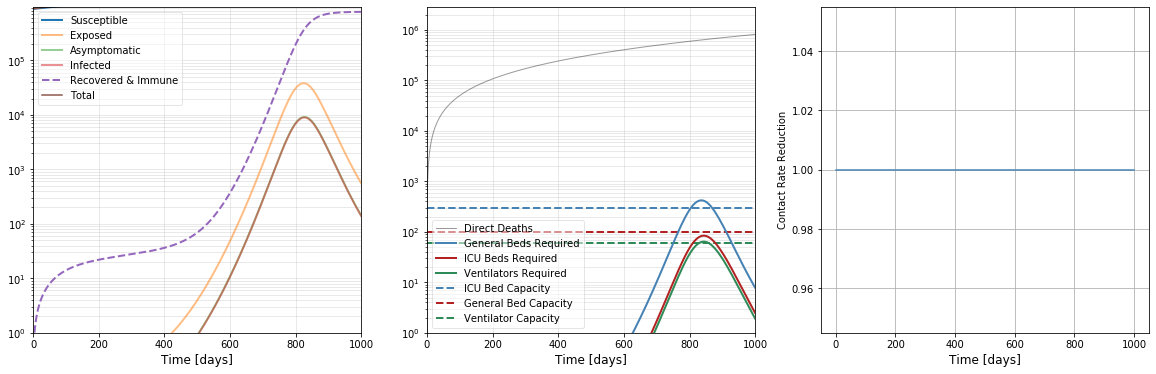

In [86]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
A_initial = np.zeros(age_group_sizes.shape[0])
A_initial[5] += 1
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=A_initial,
    I_initial=np.zeros(age_group_sizes.shape[0]),  
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    age_bin_edges=age_bin_edges,
    t_list=np.linspace(0, 1000, 1000),
    R0=0.99,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

Note there is a instability here due to birth rate.

##### When birth_rate  = 0

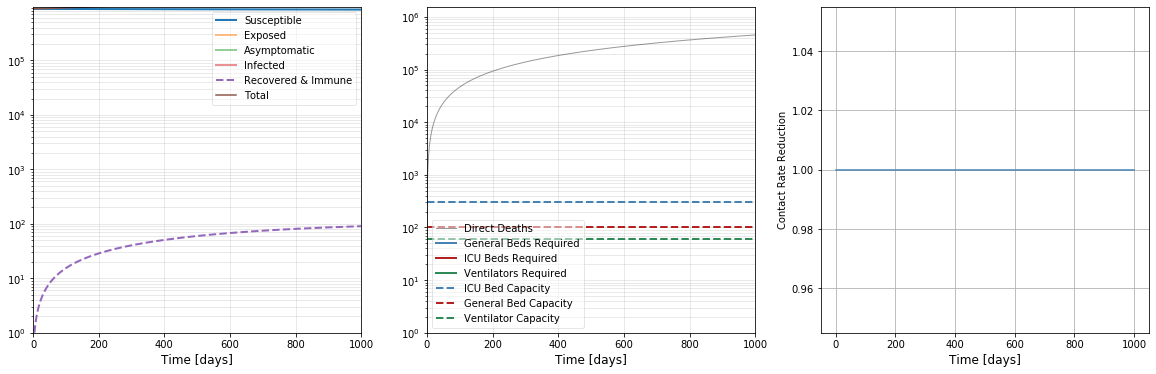

In [89]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
A_initial = np.zeros(age_group_sizes.shape[0])
A_initial[5] += 1
model = SEIRModelAge(
    N=age_group_sizes,
    A_initial=A_initial,
    I_initial=np.zeros(age_group_sizes.shape[0]),  
    R_initial=np.zeros(age_group_sizes.shape[0]),
    E_initial=np.zeros(age_group_sizes.shape[0]),
    HGen_initial=np.zeros(age_group_sizes.shape[0]),
    HICU_initial=np.zeros(age_group_sizes.shape[0]),
    HICUVent_initial=np.zeros(age_group_sizes.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    age_bin_edges=age_bin_edges,
    t_list=np.linspace(0, 1000, 1000),
    birth_rate=0,
    R0=0.99,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()